# Music Genre Classification using Recurrent Neural Network (RNN), Long short-term memory (LSTM), Gated recurrent unit (GRU) models and Mel-frequency coefficients (MFCCs)

### 0. Importing libraries, setting up device agnostic code

We start by importing the main needed libraries to run the script. Then we check the GPU properties and set up device agnostic code. In this manner, if a GPU is available, it will be used. Furthermore, we set a random seed so that a fixed seed will maintain consistency in experimental results. This will also make it easier to compare different approaches.

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchaudio.datasets import GTZAN
import matplotlib.pyplot as plt

In [2]:
# Set random seeds
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
!nvidia-smi

Tue Sep 30 11:57:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.15                 Driver Version: 581.15         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX150         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   51C    P0            N/A  / 5001W |       0MiB /   2048MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Loading data

We load the data from the respective `.json` file in the current directory. Data is loaded as numpy arrays. Those arrays are used to create PyTorch tensors. We are also going to create a *classes* list in order to use the name of the classes for predictions later.

The RNN models expect the following shape as input: `(batch_size, seq_len, input_size)`. Those values are:
* `seq_len`: This is the quantity of time steps that we have. In our case it is the `time_frames`.
* `input_size`: This is the size of the "vector" that describes each step. In our case, it is the `mfcc_coefficients` which is 13. As we "describe/analyze" each step in 13 coefficients.

As a result, our shape should be:  `(batch_size, time_frames, mfcc_coefficients)`. The shape we get from the `.json` file is already set to produce the following shape: `(time_frames, mfcc_coefficients)`. So, our size will be `(num_samples, time_frames, mfcc_coefficients)`. When the DataLoaders will be set, we will have `batch_size` instead of `num_samples` (the number of samples).

In [5]:
# Create function to load mfcc data from json file
DATASET_PATH = "data_full.json"

def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

    # Convert
    X = np.array(data['mfcc'])
    y = np.array(data['labels'])

    return X, y

In [6]:
# Create function to load classes from json file
DATASET_PATH = "data_full.json"

def load_classes(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)
    classes = data['mapping']
    return classes

In [7]:
# Load classes
classes = load_classes(DATASET_PATH)
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [8]:
# Load data
inputs, labels = load_data(DATASET_PATH)
inputs.shape, labels.shape

((9996, 130, 13), (9996,))

In [9]:
# Turn data into tensors, also unsqueeze , to be ready for RNN
X = torch.from_numpy(inputs).float() # weight calculations expect float
y = torch.from_numpy(labels).long() # CrossEntropyLoss expects long
X.shape, y.shape

(torch.Size([9996, 130, 13]), torch.Size([9996]))

### 2. Create DataSets and DataLoaders

In order to use the data in our model, we have to organize it into PyTorch DataLoaders.
After loading the data, we split them into three sets: train_set, validation_set and test_set. The validation_set will be used during the training for evaluation. The test_set will be used after the model is ready. In order for it to be exposed in never seen data.

After dividing the sets, we create the respective datasets and dataloaders.

In [10]:
# Creating a function to divide the sets
def divide_sets(X, y, test_size, validation_size, random_state=None):

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [11]:
# Create train, validation and test sets test size is 25% of the whole set. Validation size is 20% of the remaining train_set
X_train, X_validation, X_test, y_train, y_validation, y_test = divide_sets(X, y, test_size=0.25,
                                                                                validation_size=0.2,
                                                                                random_state=RANDOM_SEED)

In [12]:
# Check if data is divided correctly
print(X.shape[0] == X_train.shape[0] + X_validation.shape[0] + X_test.shape[0])
print(y.shape[0] == y_train.shape[0] + y_validation.shape[0] + y_test.shape[0])

True
True


In [13]:
# Create datasets and dataloaders
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE=32
torch.manual_seed(RANDOM_SEED)

train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=BATCH_SIZE,)
test_dataloader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(validation_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000226DF236610>, <torch.utils.data.dataloader.DataLoader object at 0x00000226DD9C6850>)
Length of train dataloader: 188 batches of 32
Length of validation dataloader: 47 batches of 32
Length of test dataloader: 79 batches of 32


In [14]:
# Checking the dataset shapes using test_dataset
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(test_features_batch.shape, "-> (batch_size, time_frames, mfcc_coefficients)")
print(test_labels_batch.shape, "-> (batch_size,) each entry is the class index of a sample")
print(test_features_batch[0].shape, "-> (time_frames, mfcc_coefficients)")
print(test_labels_batch[0], "-> (label)")

torch.Size([32, 130, 13]) -> (batch_size, time_frames, mfcc_coefficients)
torch.Size([32]) -> (batch_size,) each entry is the class index of a sample
torch.Size([130, 13]) -> (time_frames, mfcc_coefficients)
tensor(1) -> (label)


### 3. Data visualization

For better perception of the subject, we implement some visualization of the data. We use matplotlib libraries to visualize an mfcc representation of the first example. The data has to be turned into numpy arrays in order to be processed by matplotlib.
In the picture, we can distinguish the 13 coefficients in the vertical axis as parallel lines of the same thickness.

A second visualization is implemented later, in order to view various representations of different genres.

The music genre of each representation can also be viewed.


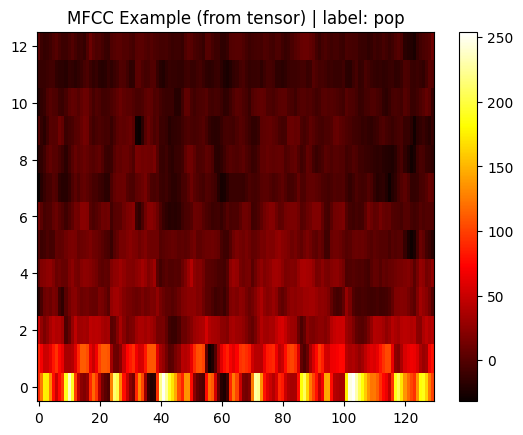

In [15]:
# Visualise data
np.random.seed(RANDOM_SEED)
CLASS_NUM = np.random.randint(len(X))
mfcc_example = X[CLASS_NUM].numpy().T # .T is used because shape of X is (time_frames, mfcc_coefficients)
plt.imshow(mfcc_example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar()
plt.title(f"MFCC Example (from tensor) | label: {classes[y[CLASS_NUM]]}")
plt.show()

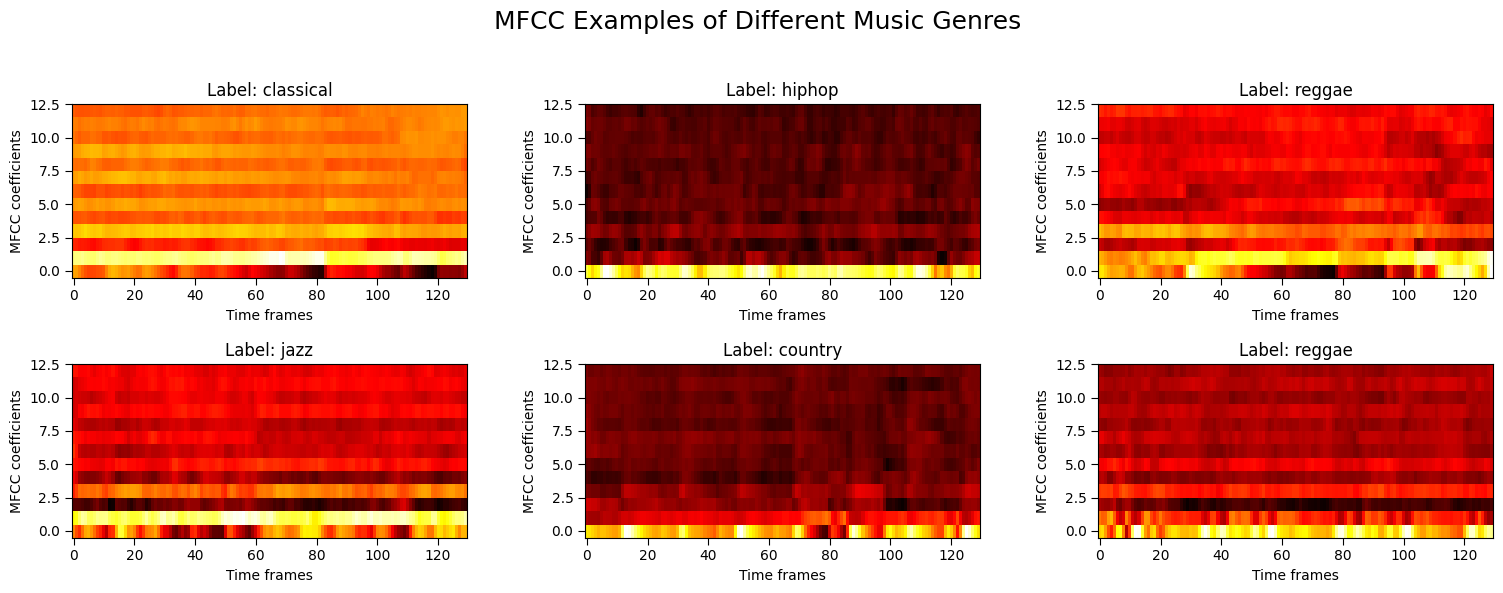

In [16]:
# Vizualize different genres
np.random.seed(RANDOM_SEED)
indices = np.random.choice(len(X), size=6, replace=False)

fig, axs = plt.subplots(2, 3, figsize=(15, 6),constrained_layout=False)
fig.suptitle("MFCC Examples of Different Music Genres", fontsize=18)

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3
    mfcc_example = X[idx].numpy().T
    im = axs[row, col].imshow(mfcc_example, cmap='hot', aspect='auto', origin='lower')
    axs[row, col].set_title(f"Label: {classes[y[idx]]}")
    axs[row, col].set_xlabel("Time frames")
    axs[row, col].set_ylabel("MFCC coefficients")
    axs[row, col].tick_params(axis='both', which='both', length=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### 4. Building a basic RNN model

The architecture of our model will be based on a simple RNN model. In order to build our model, PyTorch provides us with the `torch.nn.RNN()` class. Using that class we can set our network to have two stacked recurrent layers. The second RNN will take the outputs of the first RNN and compute the final results.
After the RNN layer it is common to use a fully connected layer in order to map the hidden state features of the RNN layer, to our number of classes.

Defining the `forward()` method has the following steps:
1. First we need to set an initial hidden state. The RNN cell has two inputs. The actual data input, as well as the hidden state, which is the output of the previous step. For our first recursion, we do not have a previous step, se we define `h0` in our code as a tensor full of zeros, of the appropriate shape, as set by PyTorch.
2. At first we pass our data through the `RNN()` layer. This will produce two outputs:
    * A tensor with all the outputs of each step.
    * A tensor with the final hidden state of each of the stacked RNN layers.
    We keep the first tensor and ignore the second output.
3. At this point we have two options. We can either "feed" the fully connected layer with one of the next two:
    1. Only the outputs of the last hidden state. This state "takes in consideration" all the previous hidden states.
    2. The outputs of all the hidden state. This will be a much larger tensor. In this manner, we have much more data in the last layer to work with.

For our RNN implementation, we are going to try two models:
1. `model_0`: In this model we are only going to use the last hidden state of the RNN layers. In order to do that, we will use slicing. The output that we get from the `RNN()` layer, is of shape `(batch_size, sequence_length, hidden_size)` where `sequence_length` is actually the `time_frames` of the MFCCs. So with this tensor we have the neuron outputs of the network, for each MFCC time frame, for each batch. Since we just want the last hidden output, this corresponds to the recursion that took place for the last sequence. As a result we will use `[:, -1, :]` to get that from the tensor ourput of the `RNN()` layer. Another way to do that, is to actually not ignore the second output of the `RNN()` layer and define it as a variable. Since this tensor will include the 2 hidden states we can get the last one with the following code:
    ```
    out, h_n = self.rnn(x, h0)
    out = h_n[-1]  # last layer’s hidden state
    ```
2. `model_2`: In this model we are going to use all the hidden states of the RNN layers. This means that the `nn.linear()` of the fully connected layer will expect an input of size `hidden_size * sequence_length`. This code of this model will be the same as previous except for the input if the fully connected layer that we already mentioned, as well as the tensor that will feed it. After getting the output tensor of the `RNN()`, we will use the `reshape()` method to get the appropriate tensor. More specifically, if the output tensor of the `RNN()` is named `out`, we will use `out.reshape(out.shape[0], -1)`. The tensor we want needs to have the `batch_size` on dim=0 and all the data on dim=`. The first argument (`out.shape[0]`) outputs the `batch_size` and the second argument (`-1`) is a PyTorch setting that puts all the data in the remaining dimension accordingly.

In [17]:
# Building an RNN model that uses only the last hidden state
INPUT_SIZE = 13 # number of mfccs
HIDDEN_SIZE = 128 # number of neurons that the hidden state has
NUM_LAYERS = 2 # number of stacked RNN layers that are going to be used
NUM_CLASSES = 10

class RNNClassifierV0(nn.Module):
    def __init__(self, input_size=13,
                 hidden_size=128,
                 num_layers=2,
                 num_classes=10):
        super().__init__()

        # defining the attributes here, in order to use them later in the forward() method
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # defining the network layers
        self.rnn = nn.RNN(input_size,
                          hidden_size,
                          num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, # using the hidden_size here because only the last hidden state will be used
                            num_classes)

    def forward(self, x):
        # an initial hidden state must be used first.
        # The dimensions/arguments we set it to have are predifined by PyTorch.
        h0 = torch.zeros(self.num_layers,
                         x.size(0),
                         self.hidden_size).to(device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]

        # pass through the fully connected layer, to produce logits for 10 classes by mapping last hidden state to output classes
        out = self.fc(out)
        return out

In [18]:
# Create model and put it to device
torch.manual_seed(RANDOM_SEED)
model_0 = RNNClassifierV0(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
model_0

RNNClassifierV0(
  (rnn): RNN(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [19]:
# Building an RNN model that uses all the hidden states
INPUT_SIZE = 13 # number of mfccs
HIDDEN_SIZE = 128 # number of neurons that the hidden state has
NUM_LAYERS = 2 # number of stacked RNN layers that are going to be used
NUM_CLASSES = 10
SEQUENCE_LENGTH = 130 # number of time frames


class RNNClassifierV1(nn.Module):
    def __init__(self, input_size=13,
                 hidden_size=128,
                 num_layers=2,
                 num_classes=10,
                 sequence_length=130):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size,
                          hidden_size,
                          num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length,
                            num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        out = self.fc(out)
        return out

In [20]:
# Create model and put it to device
torch.manual_seed(RANDOM_SEED)
model_1= RNNClassifierV1(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, SEQUENCE_LENGTH).to(device)
model_1

RNNClassifierV1(
  (rnn): RNN(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16640, out_features=10, bias=True)
)

In [21]:
# Extracting a sample
example, _ = next(iter(train_dataloader))
example.shape, example[0].shape

(torch.Size([32, 130, 13]), torch.Size([130, 13]))

In [22]:
# Testing with a forward pass
print(model_0(example.to(device))[:5])
print(model_1(example.to(device))[:5])

tensor([[ 0.0130, -0.4554, -0.8117, -0.0988,  0.0669, -0.2264, -0.0314, -0.6968,
          0.0051,  0.3989],
        [ 0.0850, -0.6000, -0.3766, -0.1774,  0.0553, -0.6535,  0.1786, -0.2815,
         -0.0139,  0.3543],
        [ 0.1042,  0.2359, -0.2278,  0.4963, -0.3137, -0.1977,  0.1220,  0.0452,
         -0.2640,  0.2576],
        [-0.0536, -0.2708, -0.5796, -0.0440, -0.2123, -0.4184, -0.1040, -0.5275,
         -0.0199,  0.7122],
        [ 0.1654, -0.3447, -0.4896, -0.4161,  0.1666, -0.6336, -0.0754, -0.1545,
          0.1887,  0.3903]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[ 0.1513,  0.2070,  0.1893,  0.5262,  0.1904, -0.0081, -0.0040, -0.5339,
          0.5901,  0.1467],
        [-0.1890,  0.1246,  0.1185,  0.5137, -0.1769,  0.0126,  0.2323, -0.1845,
          0.1199,  0.4721],
        [-0.2858,  0.4038, -0.2212, -0.1482,  0.2019, -0.2340,  0.2452, -0.4918,
          0.3798,  0.1162],
        [ 0.0155,  0.2299,  0.1118,  0.2606, -0.0883, -0.1891,  0.4437, -0.2697,
   

### 5. Training the RNN models

We start by setting a loss function and an optimizer. Two crucial elements of the training procedure.

In order to implement the training pipeline, we will create two separate functions:
* `train_step()`: This function is responsible for the training of the model. It also includes the logic for calculating the accuracy. We could use `torchmetrics.accuracy()`, but instead one can calculate it. We use the `argmax()` method after applying a `softmax()` on the logits that are extracted from the model. This calculation gives us the predicted label, because it returns the index of the highest probability. After that, the accuracy is calculated as the sum of predicted labels that are the same as the labels, divided by the number of samples.
* `test_step()`: This function will evaluate the loss and accuracy on a set. Initially we will use it on the evaluation set during training.

Those two functions are combined in the `train()` function in order to train the model for a set number of epochs. We also use the `timeit` library to set a timer in order to time the training. The `train()` function returns a dictionary with the results, in order to use them for plotting.

In [31]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.Adam(model_0.parameters(),
                               lr=0.0001)
optimizer_1 = torch.optim.Adam(model_1.parameters(),
                               lr=0.0001)

In [32]:
# Create a train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
# Create test loop function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
# Create train function by combining train_step and test_step
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [35]:
# Training model_0
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer_0,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0136 | train_acc: 0.2829 | test_loss: 1.8440 | test_acc: 0.3391
Epoch: 2 | train_loss: 1.7761 | train_acc: 0.3705 | test_loss: 1.7144 | test_acc: 0.3897
Epoch: 3 | train_loss: 1.6661 | train_acc: 0.4034 | test_loss: 1.6233 | test_acc: 0.4329
Epoch: 4 | train_loss: 1.5699 | train_acc: 0.4463 | test_loss: 1.5735 | test_acc: 0.4312
Epoch: 5 | train_loss: 1.5111 | train_acc: 0.4712 | test_loss: 1.5089 | test_acc: 0.4573
Epoch: 6 | train_loss: 1.4500 | train_acc: 0.4866 | test_loss: 1.4738 | test_acc: 0.4651
Epoch: 7 | train_loss: 1.4138 | train_acc: 0.4981 | test_loss: 1.4830 | test_acc: 0.4606
Epoch: 8 | train_loss: 1.3910 | train_acc: 0.5079 | test_loss: 1.4280 | test_acc: 0.4928
Epoch: 9 | train_loss: 1.3355 | train_acc: 0.5292 | test_loss: 1.4144 | test_acc: 0.4917
Epoch: 10 | train_loss: 1.3833 | train_acc: 0.5046 | test_loss: 1.4555 | test_acc: 0.4664
Epoch: 11 | train_loss: 1.3092 | train_acc: 0.5434 | test_loss: 1.3573 | test_acc: 0.5115
Epoch: 12 | train_l

In [36]:
# Training model_1
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer_1,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5107 | train_acc: 0.4523 | test_loss: 1.3293 | test_acc: 0.5129
Epoch: 2 | train_loss: 1.1873 | train_acc: 0.5797 | test_loss: 1.1925 | test_acc: 0.5594
Epoch: 3 | train_loss: 1.0136 | train_acc: 0.6500 | test_loss: 1.1508 | test_acc: 0.5768
Epoch: 4 | train_loss: 0.8943 | train_acc: 0.6966 | test_loss: 1.1113 | test_acc: 0.5949
Epoch: 5 | train_loss: 0.7991 | train_acc: 0.7334 | test_loss: 1.0738 | test_acc: 0.6103
Epoch: 6 | train_loss: 0.7087 | train_acc: 0.7715 | test_loss: 1.0635 | test_acc: 0.6182
Epoch: 7 | train_loss: 0.6376 | train_acc: 0.7994 | test_loss: 1.1770 | test_acc: 0.5919
Epoch: 8 | train_loss: 0.5890 | train_acc: 0.8182 | test_loss: 1.0904 | test_acc: 0.6199
Epoch: 9 | train_loss: 0.5287 | train_acc: 0.8460 | test_loss: 1.1017 | test_acc: 0.6076
Epoch: 10 | train_loss: 0.4720 | train_acc: 0.8698 | test_loss: 1.0569 | test_acc: 0.6236
Epoch: 11 | train_loss: 0.4251 | train_acc: 0.8892 | test_loss: 1.0455 | test_acc: 0.6521
Epoch: 12 | train_l

### 6. Plotting the results of the RNN models

We define a helper function named `plot_loss_curves()` to plot the results. We then use matplotlib to see how our model performed.

In [37]:
# Check the model_0_results keys (they are the same as model_1)
print(model_0_results.keys())

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


In [38]:
# Define a plotting function
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

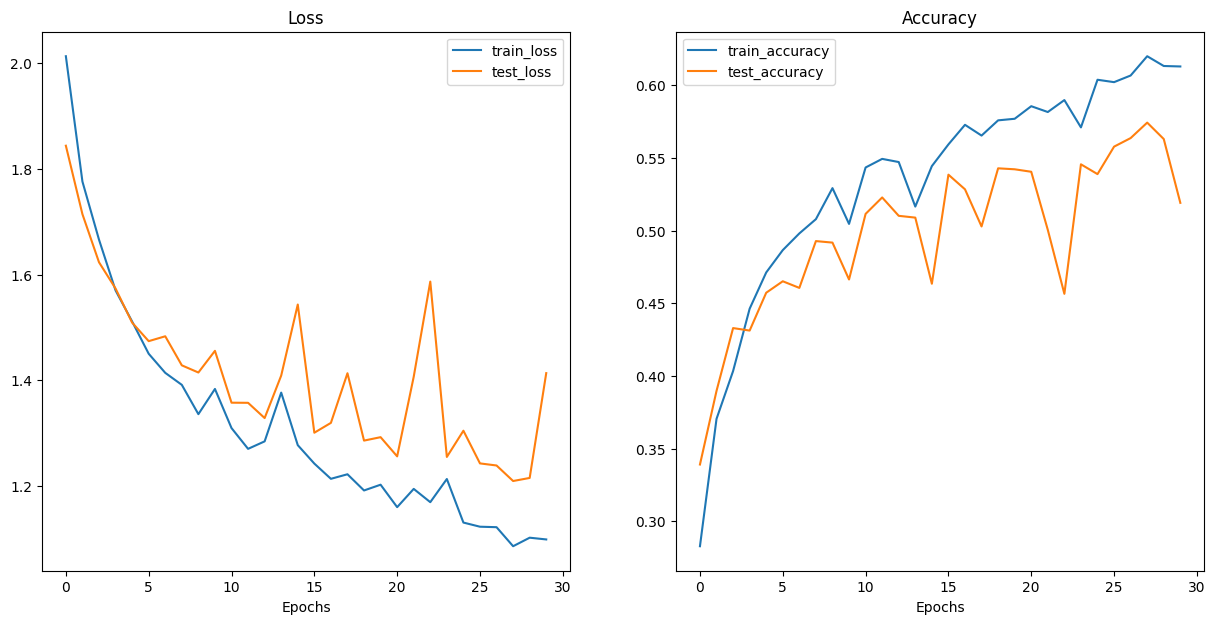

In [39]:
# Plotting the results of model_0
plot_loss_curves(model_0_results)

We can see that `model_0` only with 30 epochs, reaches almost 55% accuracy. Since we have 10 classes, a random guess would have 10% success. This is quite good and further experimentation could potentially produce better results.

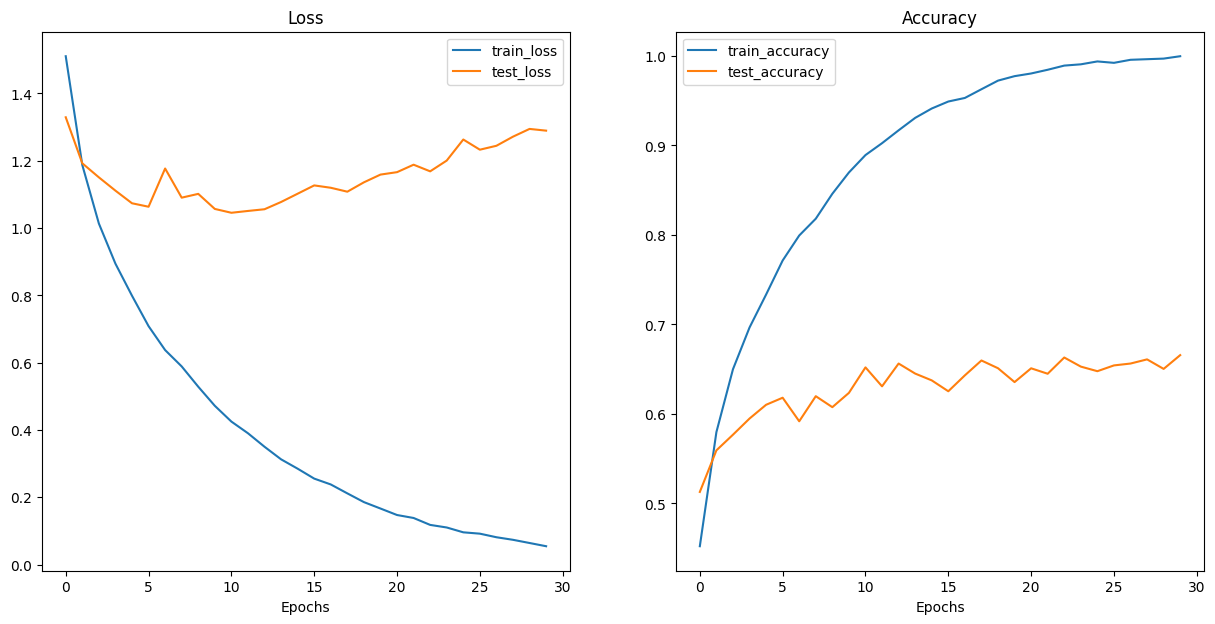

In [40]:
# Plotting the results of model_1
plot_loss_curves(model_1_results)

In the case of `model_1` it is obvious that overfitting occurs from the very early stages of training. This is actually a very common problem when using data from all the hidden stages and it appears to be one of the disadvantages of following this method.

### 7. Building a basic LSTM model

Better results are expected with the use of an LSTM model.
This neural network is similar to the RNN architecture, though it features some extra attributes in order to fix some common issues of the RNN.
* __Unstable gradients__: The weight of the feedback loop can cause problems on the gradient descent equation. This weight refers to the _reccurent weight matrix_ that connects the hidden state of the previous state, with the current one. In case that weight is larger than one, repeated multiplication during backpropagation can lead to a very large number, which causes __exploding gradients__. On the other hand, if the value of the weight is less than one, it can lead to a very small number, which causes __vanishing gradients__.
* __Long term memory__: RNNs tend to "forget" old data. This happens due to exploding/vanishing gradients.

In order to solve this problems, LSTMs implement a _cell state_, apart from the _hidden state_. This is responsible for storing data from older recursions in time. As a result, building the LSTM class for our model, should include an initial cell state (`c0`) apart from the initial hidden state (`ho`) in the `forward()` method. This cell state reflects a long-term memory for the network. Other than that, PyTorch includes an `LSTM()` layer, which is used same as the `RNN()` layer.

After building the class and instantiatiing a model, we follow the same pipeline as with the RNNs in order to train the model and plot the results for evaluation.

In [41]:
# Building the LSTM model
INPUT_SIZE = 13 # number of mfccs
HIDDEN_SIZE = 128 # number of neurons that the hidden state has
NUM_LAYERS = 2 # number of stacked LSTM layers that are going to be used
NUM_CLASSES = 10

class LSTMClassifierV0(nn.Module):
    def __init__(self, input_size=13,
                 hidden_size=128,
                 num_layers=2,
                 num_classes=10):
        super().__init__()

        # defining the attributes here, in order to use them later in the forward() method
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # defining the network layers
        self.lstm = nn.LSTM(input_size,
                           hidden_size,
                           num_layers,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, # using the hidden_size here because only the last hidden state will be used
                            num_classes)

    def forward(self, x):
        # an initial hidden state and cell state must be used first.
        # The dimensions/arguments we set it to have are predifined by PyTorch.
        h0 = torch.zeros(self.num_layers,
                         x.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers,
                         x.size(0),
                         self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0,c0))
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]

        # pass through the fully connected layer, to produce logits for 10 classes by mapping last hidden state to output classes
        out = self.fc(out)
        return out

In [42]:
# Create model and put it to device
torch.manual_seed(RANDOM_SEED)
model_2 = LSTMClassifierV0(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
model_2

LSTMClassifierV0(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [43]:
# Extracting a sample and testing it with a forward pass
example, _ = next(iter(train_dataloader))
print(model_2(example.to(device))[:5])

tensor([[-0.0012,  0.0032,  0.0742,  0.0058, -0.0120,  0.0420, -0.1865,  0.0657,
         -0.0846, -0.0004],
        [-0.0252, -0.0067,  0.1068, -0.0894, -0.0014, -0.0868, -0.0577,  0.0723,
         -0.2151, -0.0767],
        [ 0.0857, -0.0093,  0.0344, -0.1445,  0.0764,  0.0079, -0.0586,  0.0171,
         -0.1553, -0.0077],
        [ 0.0372,  0.0285,  0.0758, -0.0749, -0.0340, -0.0584, -0.1107,  0.0845,
         -0.1450,  0.0341],
        [ 0.0260,  0.0335,  0.0496, -0.1229,  0.0290, -0.0844, -0.0097,  0.0374,
         -0.1436, -0.0668]], device='cuda:0', grad_fn=<SliceBackward0>)


In [44]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                               lr=0.0001)

# Training model_2
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0888 | train_acc: 0.2823 | test_loss: 1.8215 | test_acc: 0.3628
Epoch: 2 | train_loss: 1.6618 | train_acc: 0.4115 | test_loss: 1.5485 | test_acc: 0.4651
Epoch: 3 | train_loss: 1.4532 | train_acc: 0.4933 | test_loss: 1.3958 | test_acc: 0.5129
Epoch: 4 | train_loss: 1.3299 | train_acc: 0.5331 | test_loss: 1.3373 | test_acc: 0.5343
Epoch: 5 | train_loss: 1.2775 | train_acc: 0.5521 | test_loss: 1.2838 | test_acc: 0.5435
Epoch: 6 | train_loss: 1.2290 | train_acc: 0.5613 | test_loss: 1.2583 | test_acc: 0.5575
Epoch: 7 | train_loss: 1.1699 | train_acc: 0.5819 | test_loss: 1.2341 | test_acc: 0.5673
Epoch: 8 | train_loss: 1.1358 | train_acc: 0.6032 | test_loss: 1.2076 | test_acc: 0.5740
Epoch: 9 | train_loss: 1.1152 | train_acc: 0.6002 | test_loss: 1.1727 | test_acc: 0.5902
Epoch: 10 | train_loss: 1.0803 | train_acc: 0.6179 | test_loss: 1.2669 | test_acc: 0.5333
Epoch: 11 | train_loss: 1.0886 | train_acc: 0.6114 | test_loss: 1.1636 | test_acc: 0.5734
Epoch: 12 | train_l

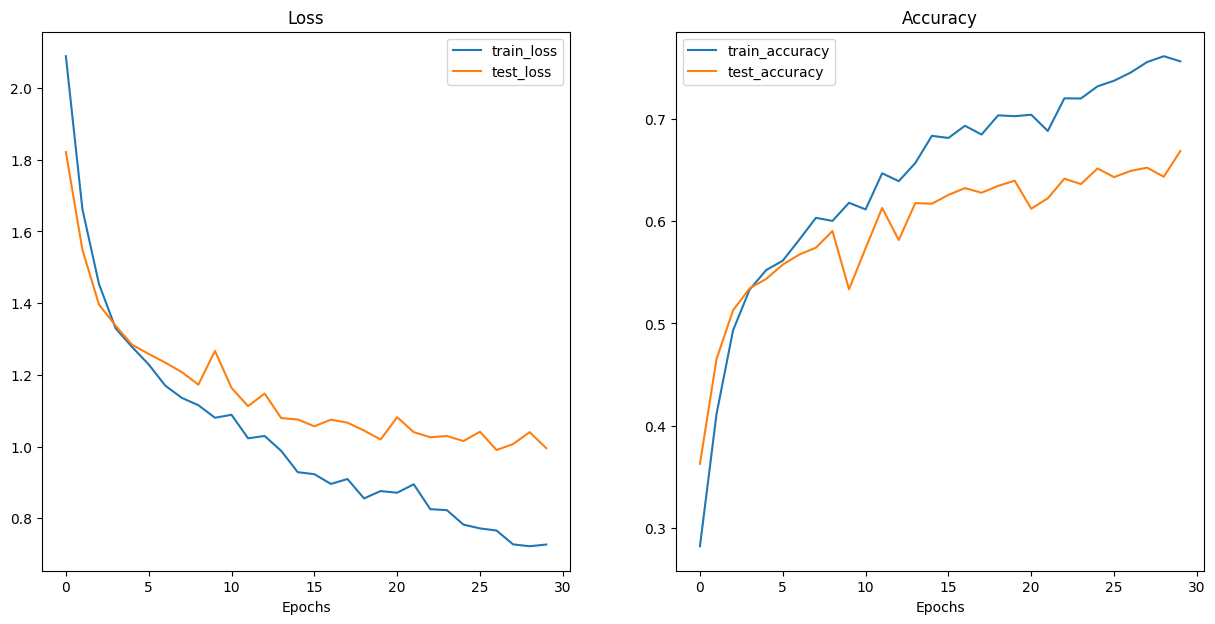

In [45]:
# Plotting the results of model_2
plot_loss_curves(model_2_results)

The LSTM model appears to be performing better than the RNN on our problem. We see that after the 10th epoch some overfitting is starting to develop. However, we could have stopped the training at this point and `model_2` would already be performing better than `model_0`. As we see that already from the 10th epoch, the accuracy on the validation set is above 60%.

### 8. Building a basic GRU model

The GRU cell is a simplified version of an LSTM cell. There is not a seperate output for the long-term memory state. The whole state is output at every timestep. As a result, there is no need to define an initial cell state in the `forward()` method, like in the LSTM. PyTorch includes a `GRU()` layer that works like the `RNN()` and the `LSTM()` class. So all in all, the GRU class that we are going to build is identical to the RNN. Only difference is using the `GRU()` layer, instead of the `RNN()`.

After building the class and instantiatiing a model, we follow the same pipeline as before in order to train the model and plot the results for evaluation.


In [46]:
# Building a GRU model
INPUT_SIZE = 13 # number of mfccs
HIDDEN_SIZE = 128 # number of neurons that the hidden state has
NUM_LAYERS = 2 # number of stacked GRU layers that are going to be used
NUM_CLASSES = 10

class GRUClassifierV0(nn.Module):
    def __init__(self, input_size=13,
                 hidden_size=128,
                 num_layers=2,
                 num_classes=10):
        super().__init__()

        # defining the attributes here, in order to use them later in the forward() method
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # defining the network layers
        self.gru = nn.GRU(input_size,
                          hidden_size,
                          num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, # using the hidden_size here because only the last hidden state will be used
                            num_classes)

    def forward(self, x):
        # an initial hidden state must be used first.
        # The dimensions/arguments we set it to have are predifined by PyTorch.
        h0 = torch.zeros(self.num_layers,
                         x.size(0),
                         self.hidden_size).to(device)

        # Forward propagate RNN
        out, _ = self.gru(x, h0)
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]

        # pass through the fully connected layer, to produce logits for 10 classes by mapping last hidden state to output classes
        out = self.fc(out)
        return out

In [47]:
# Create model and put it to device
torch.manual_seed(RANDOM_SEED)
model_3 = GRUClassifierV0(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
model_3

GRUClassifierV0(
  (gru): GRU(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
# Extracting a sample and testing it with a forward pass
example, _ = next(iter(train_dataloader))
print(model_3(example.to(device))[:5])

tensor([[ 0.6876,  0.0852,  0.0275,  0.0497, -0.1414,  0.0095, -0.0322, -0.3056,
          0.0058,  0.2350],
        [ 0.2430, -0.0446, -0.0027, -0.0619, -0.1306, -0.3438, -0.0667, -0.3142,
          0.0154,  0.2655],
        [ 0.2086,  0.2508,  0.5311, -0.1034,  0.0780, -0.0422, -0.0468, -0.2080,
          0.1385, -0.0233],
        [ 0.2800, -0.1192,  0.6844, -0.1721,  0.0313,  0.2482, -0.3439,  0.0380,
          0.2764, -0.2325],
        [ 0.0087,  0.0576,  0.3357, -0.2558,  0.2235,  0.1078, -0.0647, -0.2682,
          0.2970, -0.0058]], device='cuda:0', grad_fn=<SliceBackward0>)


In [49]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                               lr=0.0001)

# Training model_3
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9881 | train_acc: 0.3077 | test_loss: 1.7945 | test_acc: 0.3658
Epoch: 2 | train_loss: 1.6826 | train_acc: 0.4049 | test_loss: 1.6061 | test_acc: 0.4483
Epoch: 3 | train_loss: 1.5070 | train_acc: 0.4747 | test_loss: 1.4575 | test_acc: 0.4943
Epoch: 4 | train_loss: 1.3539 | train_acc: 0.5249 | test_loss: 1.3269 | test_acc: 0.5229
Epoch: 5 | train_loss: 1.2289 | train_acc: 0.5696 | test_loss: 1.2342 | test_acc: 0.5582
Epoch: 6 | train_loss: 1.1294 | train_acc: 0.6102 | test_loss: 1.1392 | test_acc: 0.5875
Epoch: 7 | train_loss: 1.0468 | train_acc: 0.6375 | test_loss: 1.0839 | test_acc: 0.6160
Epoch: 8 | train_loss: 0.9641 | train_acc: 0.6666 | test_loss: 1.0463 | test_acc: 0.6237
Epoch: 9 | train_loss: 0.9045 | train_acc: 0.6876 | test_loss: 0.9897 | test_acc: 0.6554
Epoch: 10 | train_loss: 0.8446 | train_acc: 0.7122 | test_loss: 0.9460 | test_acc: 0.6662
Epoch: 11 | train_loss: 0.7826 | train_acc: 0.7325 | test_loss: 0.9177 | test_acc: 0.6782
Epoch: 12 | train_l

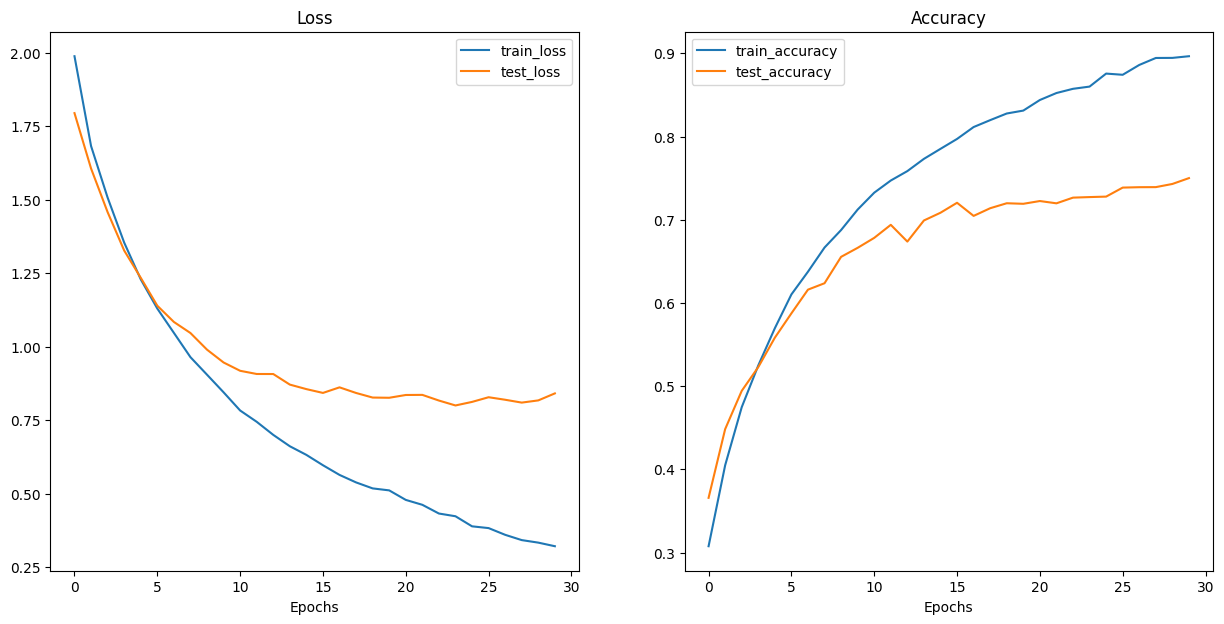

In [50]:
# Plotting the results of model_3
plot_loss_curves(model_3_results)

The GRU model appears to have as similar behaviour to this of the LSTM. It performs better than the RNN, but a small overfitting appears to start occuring after the 10th epoch. As mentioned before, there are ways to deal with this problem. However up to this point it performs better than the RNN and even better than the LSTM as we see the accuracy reaching a number above 70%.

### 9. Evaluating our models on never seen data

Finally, we are going to use the `test_dataloader` to evaluate our models.

In [51]:
# Evaluate the RNN on the test set
evaluation = test_step(model=model_0,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       )
print(f"test loss = {evaluation[0]:.4f} | test acc = {evaluation[1]:.4f}")

test loss = 1.4387 | test acc = 0.5193


In [52]:
# Evaluate the LSTM on the test set
evaluation = test_step(model=model_2,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       )
print(f"test loss = {evaluation[0]:.4f} | test acc = {evaluation[1]:.4f}")

test loss = 0.9538 | test acc = 0.6809


In [53]:
# Evaluate the GRU on the test set
evaluation = test_step(model=model_3,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       )
print(f"test loss = {evaluation[0]:.4f} | test acc = {evaluation[1]:.4f}")

test loss = 0.7633 | test acc = 0.7678


We can see that the GRU had the best performance out of the three models as it scored an accuracy of 77% which is very good considering we have 10 classes. The LSTN follows with an accuracy of 68%. The RNN comes next with an accuracy of 52%.

### 10. Creating a `predict()` function, to make predictions on unseen data

We are going to use `model_3` to make predictions. First we use the test dataloader to extract the first sample. Then we create the predict function that among other arguments, we can enter the index of the sample we want to predict. We see that we have 2499 indexes available.
The tensor that represents the sample has to be unsqueezed because the model expects a `batch_size` on dim=0. The model exports logits. Using `softmax()` we turn the logits into probabilities and with `argmax()` we take the index of the highest probability. This is actually the predicted index class. However, we can use `argmax()` right away without having the probabilites first. This is because logit values are respective to the probability values. This is actually the predicted index class. We also do that for time complexity reasons.

Changing the `model` and `index` arguments on the `predict()` function can let us make further testing.

In [54]:
# Creating the predict() function
def predict(model: torch.nn.Module,
            X_test: torch.Tensor,
            y_test: torch.Tensor,
            index: int = 0,
            device: str = "cpu",
            classes: list = classes):

    X_sample = X_test[index].unsqueeze(0).to(device)  # (1, C, H, W)
    y_sample = y_test[index].item() if isinstance(y_test[index], torch.Tensor) else y_test[index]

    model.eval()
    with torch.inference_mode():
        logits = model(X_sample)
        predicted_index = torch.argmax(logits, dim=1).item()

    print(f"Target: {classes[y_sample]}, Predicted label: {classes[predicted_index]}")

In [55]:
# Printing the shape to see how many indexes we have
X_test.shape

torch.Size([2499, 130, 13])

In [56]:
# Set random seed to define index.
np.random.seed(RANDOM_SEED) # remove this line to set a random index, for further testing
index = np.random.randint(len(X_test))
predict(model=model_3,
        X_test=X_test,
        y_test=y_test,
        index=200,
        device=device,
        classes=classes)

Target: jazz, Predicted label: jazz


### 11. Making a confusion matrix for further evaluation

For a good vizualization of our model's performance, we can use a confusion matrix for `model_3`. For that purpose we will use the `torchmetrics` and `mlxtend` library.
First we will make predictions on a test set and save the results on a tensor. Then we can use this tensor along with `y_test` which is a tensor containing the correct values for the labels of the test set.

In [57]:
# Importing libraries
import mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher. use pip install -q torchmetrics -U mlxtend"

mlxtend version: 0.23.4


In [58]:
# Make predictions on test_set and get tensor with predictions
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_3(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/79 [00:00<?, ?it/s]

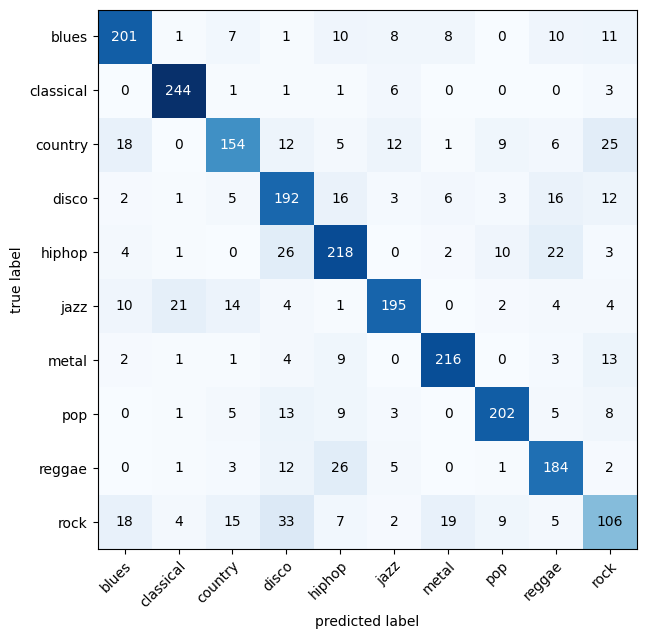

In [59]:
# Importing libraries
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test)

#  Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

We can see that our model performs quite well. One of the benefits of the confusion matrix, is that we can see what labels our model mismatches. We can see that the the genres that are most likely to be mismatched are rock and country. This is interesting, because those genres could be easily mismatched by a human as well, cause there are similar with rock or blues. We do not see that much errors in distinguishing that many genres for classical. Furthermore, one must bear in mind that the distinction of genres is based on audio features. As a result, one can expect mismatches genres that use similar instruments or music production.